In [1]:
import warnings; warnings.filterwarnings("ignore")

In [2]:
import os, sys, json
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

from copy import copy
from glob import glob
from tqdm.auto import tqdm as tqdm
import matplotlib.pyplot as plt

In [3]:
sys.path.append('../mouseland/model_opts')
from model_options import *
model_options = get_model_options()

In [4]:
%reload_ext rpy2.ipython

In [5]:
%%R --noreturn 
library('pacman')
p_load('tidyverse') 

In [7]:
all_response_data = (pd.read_csv('response/vessel_subject_data.csv')
                 .groupby(['Subj','ImageType','Image'])
                 .agg({'Rating': 'mean', 'RT': 'mean'}).reset_index())
all_response_data.columns = ['subject','image_type','image_name','rating','reaction_time']
response_data = all_response_data.groupby(['image_type','image_name'])['rating'].mean().reset_index()

In [8]:
all_response_data

,subject,image_type,image_name,rating,reaction_time
0,1,are,aep_001.jpg,3.666667,0.899933
1,1,are,aep_002.jpg,4.333333,0.761233
2,1,are,aep_004.jpg,1.000000,0.997700
3,1,are,aep_005.jpg,5.666667,0.854033
4,1,are,aep_006.jpg,6.333333,1.761233
...,...,...,...,...,...
10933,24,art,art_105.jpg,1.000000,0.836700
10934,24,art,art_106.jpg,1.000000,0.723550
10935,24,art,art_107.jpg,1.000000,0.701400
10936,24,art,art_108.jpg,1.500000,1.554850


### Data Processing

In [11]:
def process_model_data(model_string, orient='wide'):
    model_data = (pd.read_csv('metrics/vessel/{}.csv'.format(model_string)))
    model_data = model_data.drop(['model_layer_index'], axis = 1)
    model_data = model_data.rename(columns={'image': 'image_name'})
    data_wide = pd.merge(model_data, response_data, on = 'image_name')
    data_wide['model_layer_depth'] = data_wide['model_layer_depth'] + 1
    id_columns = ['image_name','image_type','model','train_type','model_layer','model_layer_depth','rating']
    data_wide = data_wide[id_columns + [col for col in data_wide.columns.to_list() if col not in id_columns]]
    data_long = pd.melt(data_wide, id_vars=id_columns, 
                var_name = 'metric', value_name='value')
    
    if orient == 'wide':
        return(data_wide)
    if orient == 'long':
        return(data_long)

In [12]:
target_model = 'alexnet_imagenet'
data_wide = process_model_data(target_model)

In [13]:
data_wide

,image_name,image_type,model,train_type,model_layer,model_layer_depth,rating,mean_activity,sparseness
0,aep_010.jpg,are,alexnet,imagenet,Conv2d-1,1,4.350877,2.098905,1.657185e-02
1,aep_010.jpg,are,alexnet,imagenet,ReLU-1,2,4.350877,0.858863,2.109780e-01
2,aep_010.jpg,are,alexnet,imagenet,MaxPool2d-1,3,4.350877,2.961494,5.579752e-01
3,aep_010.jpg,are,alexnet,imagenet,Conv2d-2,4,4.350877,14.393757,4.050440e-01
4,aep_010.jpg,are,alexnet,imagenet,ReLU-2,5,4.350877,0.600872,7.187308e-02
...,...,...,...,...,...,...,...,...,...
10111,art_016.jpg,art,alexnet,imagenet,Linear-1,14,3.333333,5.466929,3.409078e-01
10112,art_016.jpg,art,alexnet,imagenet,ReLU-6,15,3.333333,0.707121,1.532098e-01
10113,art_016.jpg,art,alexnet,imagenet,Linear-2,16,3.333333,4.720512,4.808307e-01
10114,art_016.jpg,art,alexnet,imagenet,ReLU-7,17,3.333333,0.324582,8.481777e-02


In [14]:
def process_corr_data(data_wide, orient='long'):
    model_layers = data_wide['model_layer'].unique().tolist()
    id_columns = ['model','train_type','image_type','model_layer', 'model_layer_depth']
    corr_data_wide = (data_wide.groupby(id_columns)
             .corrwith(data_wide['rating']).reset_index().drop('rating',axis = 1))
    corr_data_long = pd.melt(corr_data_wide, id_vars = id_columns, 
                             var_name = 'metric', value_name='corr')
    
    if orient == 'wide':
        return(corr_data_wide)
    if orient == 'long':
        return(corr_data_long)

In [15]:
process_corr_data(data_wide)

,model,train_type,image_type,model_layer,model_layer_depth,metric,corr
0,alexnet,imagenet,are,Conv2d-1,1,mean_activity,0.011647
1,alexnet,imagenet,are,Conv2d-2,4,mean_activity,0.027119
2,alexnet,imagenet,are,Conv2d-3,7,mean_activity,-0.068520
3,alexnet,imagenet,are,Conv2d-4,9,mean_activity,-0.176181
4,alexnet,imagenet,are,Conv2d-5,11,mean_activity,-0.276747
...,...,...,...,...,...,...,...
175,alexnet,imagenet,lsc,ReLU-3,8,sparseness,-0.382702
176,alexnet,imagenet,lsc,ReLU-4,10,sparseness,0.286813
177,alexnet,imagenet,lsc,ReLU-5,12,sparseness,0.294431
178,alexnet,imagenet,lsc,ReLU-6,15,sparseness,-0.497647


In [16]:
def max_transform(df, group_vars, measure_var = 'score', transform = max, deduplicate=True):
    if not isinstance(group_vars, list):
        group_vars = [group_vars]
    
    max_df = (df[df.groupby(group_vars)[measure_var]
                 .transform(max) == df[measure_var]]).reset_index(drop=True)
                 
    if deduplicate:
        max_df = max_df[~max_df.duplicated(group_vars + [measure_var])]
        
    return max_df

def min_transform(df, group_vars, measure_var = 'score', transform = max, deduplicate=True):
    if not isinstance(group_vars, list):
        group_vars = [group_vars]
    
    min_df = (df[df.groupby(group_vars)[measure_var]
                 .transform(min) == df[measure_var]]).reset_index(drop=True)
                 
    if deduplicate:
        min_df = min_df[~min_df.duplicated(group_vars + [measure_var])]
        
    return min_df

In [19]:
model_csvs = glob('metrics/vessel/*.csv')
target_models = [csv.split('/')[1].split('.')[0] for csv in model_csvs]

output_file = 'results/raw_results2.csv'
if os.path.exists(output_file):
    raw_results = pd.read_csv(output_file)

if not os.path.exists(output_file):
    results_dflist = []
    iterator = tqdm(target_models)
    for target_model in iterator:
        iterator.set_description(target_model)
        data_wide = process_model_data(target_model)
        
        results_dflist.append(data_wide)

    raw_results = pd.concat(results_dflist)
    raw_results.to_csv(output_file, index = None)

In [20]:
model_csvs = glob('metrics/vessel/*.csv')
target_models = [csv.split('/')[1].split('.')[0] for csv in model_csvs]

output_file = 'results/correlation_results2.csv'
if os.path.exists(output_file):
    corr_results = pd.read_csv(output_file)

if not os.path.exists(output_file):
    results_dflist = []
    iterator = tqdm(target_models)
    for target_model in iterator:
        iterator.set_description(target_model)
        data_wide = process_model_data(target_model)
        corr_data_long = process_corr_data(data_wide)
        
        results_dflist.append(corr_data_long)

    corr_results = pd.concat(results_dflist)
    corr_results.to_csv(output_file, index = None)
    
corr_results['corr_abs'] = abs(corr_results['corr'])
corr_results['corr_sq'] = corr_results['corr']**2

In [21]:
from pandas.core.base import PandasObject
def your_fun(df):
    ...
PandasObject.your_fun = your_fun

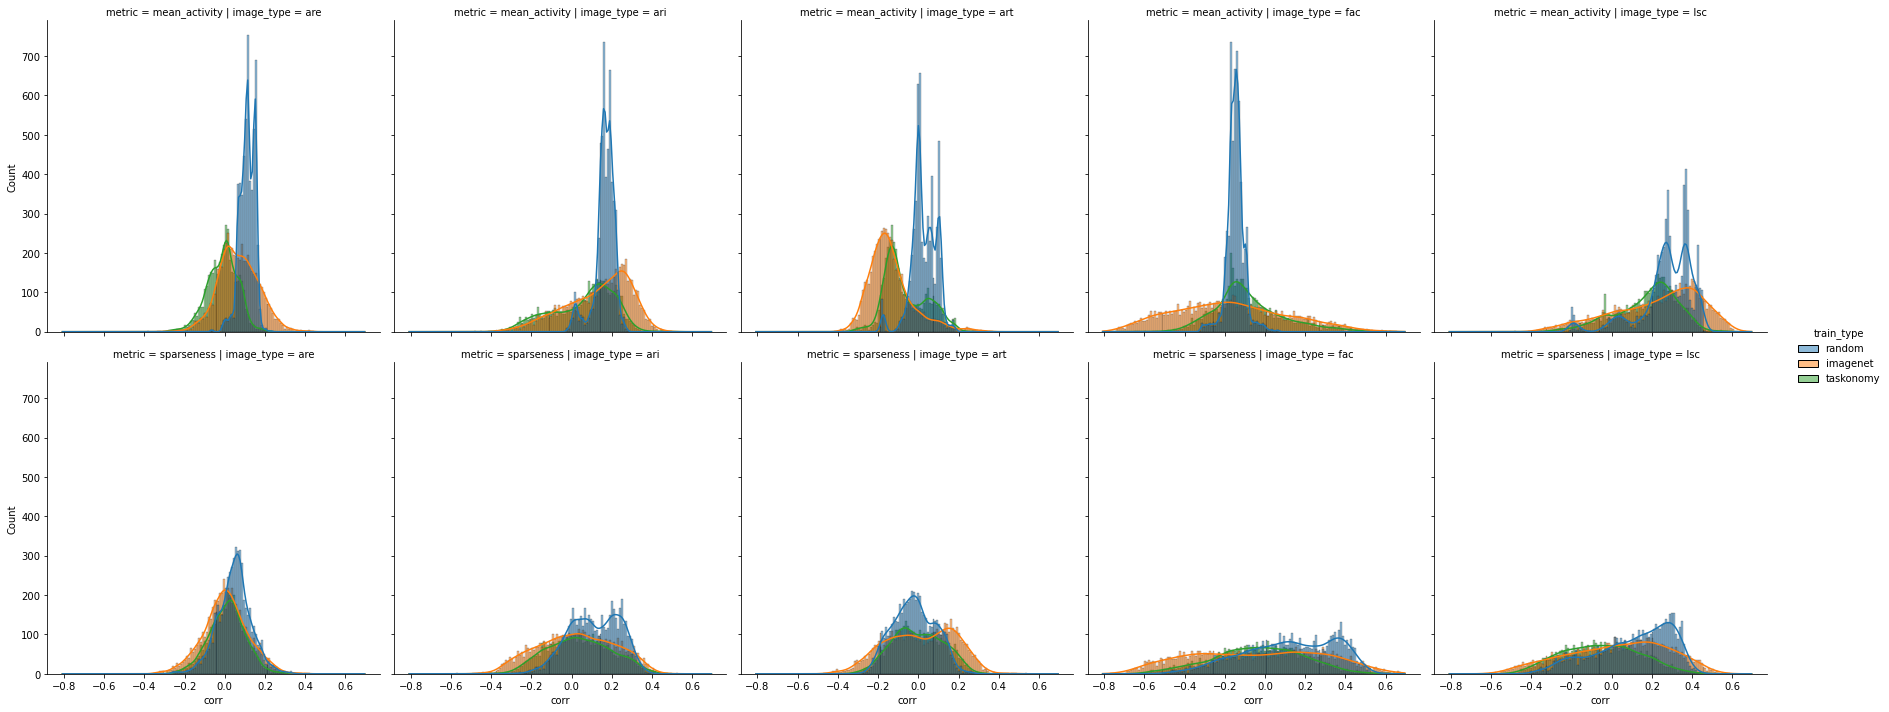

In [22]:
sns.displot(x = 'corr', hue = 'train_type', col = 'image_type', row = 'metric', kde = True, data = corr_results);

In [23]:
np.round((corr_results.query("train_type not in '{}' & image_type == '{}' & metric == '{}'".format('taskonomy','lsc','sparseness'))
 .groupby(['model','train_type','image_type','metric'])['corr'].min().reset_index().sort_values(by='corr')),5)

,model,train_type,image_type,metric,corr
32,shufflenet_v2_x0_5,imagenet,lsc,sparseness,-0.60944
20,resnet152,imagenet,lsc,sparseness,-0.59860
42,vgg11_bn,imagenet,lsc,sparseness,-0.59540
34,shufflenet_v2_x1_0,imagenet,lsc,sparseness,-0.59328
26,resnet50,imagenet,lsc,sparseness,-0.58773
46,vgg13_bn,imagenet,lsc,sparseness,-0.57972
6,densenet169,imagenet,lsc,sparseness,-0.57881
56,wide_resnet101_2,imagenet,lsc,sparseness,-0.55163
50,vgg16_bn,imagenet,lsc,sparseness,-0.55031
4,densenet161,imagenet,lsc,sparseness,-0.54681


In [24]:
(corr_results.query("train_type in '{}' & image_type == '{}' & metric == '{}'".format('taskonomy','lsc','mean_activity'))
 .groupby(['model','train_type','image_type','metric'])['corr'].max().reset_index().sort_values(by='corr'))

,model,train_type,image_type,metric,corr
8,edge_texture,taskonomy,lsc,mean_activity,0.311328
14,keypoints3d,taskonomy,lsc,mean_activity,0.328858
13,keypoints2d,taskonomy,lsc,mean_activity,0.337024
18,random_weights_taskonomy,taskonomy,lsc,mean_activity,0.337963
20,room_layout,taskonomy,lsc,mean_activity,0.351063
10,fixated_pose,taskonomy,lsc,mean_activity,0.361512
12,jigsaw,taskonomy,lsc,mean_activity,0.362062
3,curvature,taskonomy,lsc,mean_activity,0.363421
9,egomotion,taskonomy,lsc,mean_activity,0.380537
24,vanishing_point,taskonomy,lsc,mean_activity,0.385227


In [25]:
data_out = (corr_results.groupby(['model','train_type','image_type','metric'])['corr_sq'].max()
             .reset_index().sort_values(by='corr_sq'))

In [26]:
%%R -i data_out -o train_type_stats

pacman::p_load('rstatix')
        
train_type_stats <- data_out %>% filter(train_type != 'taskonomy') %>%
    group_by(model, train_type, image_type, metric) %>%
    filter(corr_sq == max(corr_sq)) %>% group_by(image_type, metric) %>%
    {left_join(t_test(., corr_sq ~ train_type, paired = TRUE) %>% 
                   adjust_pvalue(method = 'bonferroni') %>% add_significance('p.adj'),
               cohens_d(., corr_sq ~ train_type, paired = TRUE))} %>% 
    select(image_type, metric, group1, group2, p.adj, p.adj.signif, effsize, magnitude)

Joining, by = c("image_type", "metric", ".y.", "group1", "group2", "n1", "n2")


In [27]:
train_type_stats

,image_type,metric,group1,group2,p.adj,p.adj.signif,effsize,magnitude
1,are,mean_activity,imagenet,random,7.390000e-19,****,4.090799,large
2,are,sparseness,imagenet,random,1.760000e-24,****,6.497056,large
3,ari,mean_activity,imagenet,random,8.980000e-25,****,6.653487,large
4,ari,sparseness,imagenet,random,6.240000e-13,****,2.441632,large
5,art,mean_activity,imagenet,random,3.250000e-12,****,2.284678,large
6,art,sparseness,imagenet,random,6.350000e-11,****,2.019863,large
7,fac,mean_activity,imagenet,random,3.850000e-25,****,6.855074,large
8,fac,sparseness,imagenet,random,1.630000e-21,****,5.100199,large
9,lsc,mean_activity,imagenet,random,8.520000e-34,****,13.729358,large
10,lsc,sparseness,imagenet,random,1.790000e-24,****,6.493647,large


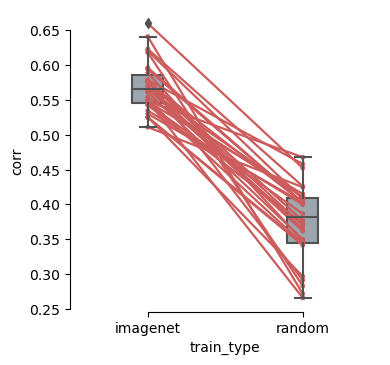

In [28]:
plot_data = (corr_results.query("train_type not in 'taskonomy' & image_type == 'lsc' & metric == 'mean_activity'")
      .groupby(['model','train_type','image_type','metric'])['corr'].max().reset_index().sort_values(by='corr'))
pg.plot_paired(data = plot_data, dv = 'corr', within = 'train_type', subject = 'model');

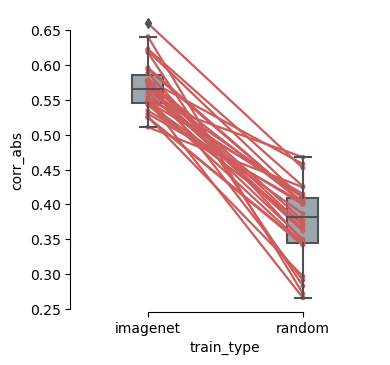

In [29]:
plot_data = (corr_results.query("train_type not in 'taskonomy' & image_type == 'lsc' & metric == 'mean_activity'")
      .groupby(['model','train_type','image_type','metric'])['corr_abs'].max().reset_index().sort_values(by='corr_abs'))
pg.plot_paired(data = plot_data, dv = 'corr_abs', within = 'train_type', subject = 'model');

In [45]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import explained_variance_score as ev_score
from sklearn.metrics import r2_score 
from sklearn.preprocessing import scale
from scipy.stats import pearsonr

def pearson_r2_score(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]**2

scoring_metrics = {'ev_score': ev_score, 'pearson_r2': pearson_r2_score}

model_csvs = glob('metrics/vessel/*.csv')
target_models = [csv.split('/')[-1].split('.')[0] for csv in model_csvs]
target_models = [model for model in target_models if 'googlenet' not in model]

output_file = 'results/analysis_results2.csv'
if os.path.exists(output_file):
    reg_results = pd.read_csv(output_file)

if not os.path.exists(output_file):
    results_dictlist = []
    iterator = tqdm(target_models)
    for target_model in iterator:
        iterator.set_description(target_model) 
        data_wide = process_model_data(target_model)
        model_layers = data_wide['model_layer'].unique()
        model_name = model_options[target_model]['model_name']
        train_type = model_options[target_model]['train_type']
        corr_results_subset = process_corr_data(data_wide)
        corr_max = min_max_transform(corr_results_subset, group_vars=['model','train_type','image_type', 'metric'], 
                                 measure_var = 'corr')

        data_long = process_model_data(target_model, orient = 'long')
        for metric in tqdm(data_long['metric'].unique(), leave=False):
            for image_type in tqdm(data_long['image_type'].unique(), leave=False):
                corr_max_subset = corr_max[(corr_max['image_type'] == image_type) & (corr_max['metric'] == metric)]
                corr_max_layer = corr_max_subset['model_layer'].iloc[0]
                corr_max_depth = corr_max_subset['model_layer_depth'].iloc[0]
                corr_max_score = corr_max_subset['corr'].iloc[0]

                # regressing correlation value on depth
                data_i = corr_results_subset[(corr_results_subset['image_type'] == image_type) & 
                                             (corr_results_subset['metric'] == metric)]
                x, y = data_i['model_layer_depth'].to_numpy().reshape(-1,1), data_i['corr'].to_numpy()
                regression = LinearRegression().fit(x,y)
                corr_depth_coef = regression.coef_[0]

                # regressing metric across layers on aesthetic rating
                data_i = data_wide[(data_wide['image_type'] == image_type)]
                y = data_i[(data_i['model_layer']==model_layers[0])]['rating'].to_numpy()
                X = np.stack([data_i[(data_i['model_layer']==model_layer)][metric].to_numpy()
                              for model_layer in model_layers], axis = 1)
                alpha_values = np.array([0.01, 0.5, 1.0, 1.5, 3.0, 5.0, 10.0])
                regression = RidgeCV(alphas=alpha_values, store_cv_values=True, 
                                     scoring='explained_variance').fit(X,y)
                ridge_gcv_score, ridge_gcv_alpha = regression.best_score_, regression.alpha_
                ridge_max_layer = model_layers[np.argmax(regression.coef_)]
                ridge_max_depth = np.argmax(regression.coef_)
                
                #regression ridge coefficient on depth
                x, y = data_i['model_layer_depth'].unique().reshape(-1,1), regression.coef_
                regression = LinearRegression().fit(x,y)
                ridge_depth_coef = regression.coef_[0]
                
                results_dictlist.append({'model': model_name, 'train_type': train_type, 
                                         'image_type': image_type, 'metric': metric,
                                         'model_depth': len(model_layers),
                                         'ridge_gcv_score': ridge_gcv_score,
                                         'ridge_gcv_alpha': ridge_gcv_alpha,
                                         'ridge_max_layer': ridge_max_layer,
                                         'ridge_max_depth': ridge_max_depth,
                                         'ridge_depth_coef': ridge_depth_coef,
                                         'ridge_max_relative_depth': ridge_max_depth / len(model_layers),
                                         'corr_max_score': corr_max_score, 
                                         'corr_max_layer': corr_max_layer,
                                         'corr_max_depth': corr_max_depth,
                                         'corr_depth_coef': corr_depth_coef,
                                         'corr_max_relative_depth': corr_max_depth / len(model_layers)})

    reg_results = pd.DataFrame(results_dictlist)
    reg_results.to_csv(output_file, index = None)
    
reg_results = np.round(reg_results, 5)

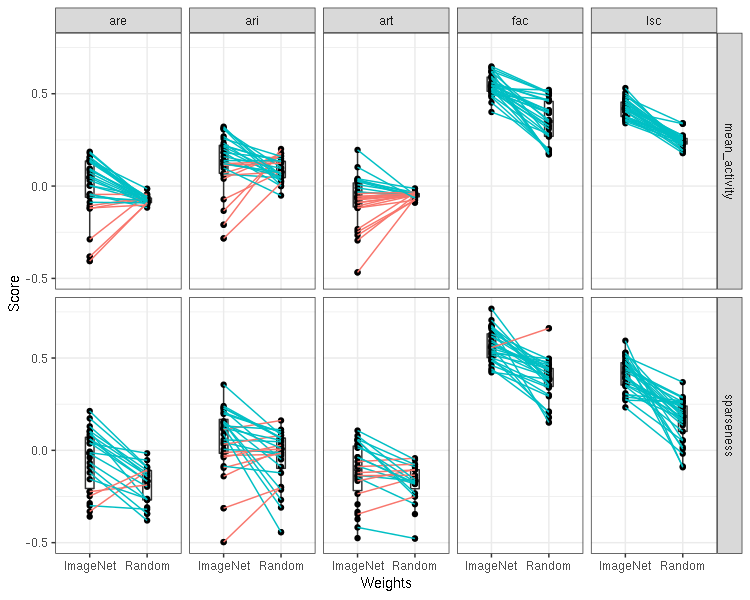

In [31]:
%%R -h 600 -w 750 --res 100 -i reg_results

pairplot_data <- reg_results %>%
    filter(train_type != 'taskonomy') %>%
    mutate(score = ridge_gcv_score) %>%
    group_by(model, metric, image_type) %>%
    mutate(slope = (score[train_type=='imagenet'] - score[train_type=='random'])/(2-1)) %>%
    mutate(train_type = fct_recode(as.factor(train_type), ImageNet = 'imagenet', Random = 'random'))

pairplot_data %>%
    filter(ridge_gcv_score > -0.5) %>%
    ggplot(aes(train_type, ridge_gcv_score)) + 
    facet_grid(vars(metric), vars(image_type)) +
    geom_boxplot(width = 0.15) + geom_point() + 
    geom_line(aes(group=model, col = slope > 0)) +
    theme_bw() + ylab('Score') + xlab('Weights') + guides(color = FALSE)
#https://stackoverflow.com/questions/40745163/jupyter-notebook-rpy2-rmagics-how-to-set-the-default-plot-size

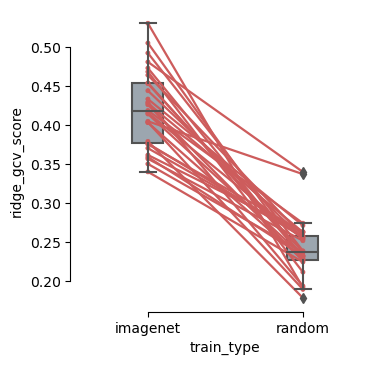

In [32]:
pairplot_data = (reg_results.query("train_type != '{}' & image_type == '{}' & metric == '{}'"
                                   .format('taskonomy','lsc','mean_activity')))
pg.plot_paired(data = pairplot_data, dv = 'ridge_gcv_score', within = 'train_type', subject = 'model');

In [33]:
reg_results.query("image_type == 'lsc' & metric == 'mean_activity' & train_type == 'taskonomy'").sort_values(by='ridge_gcv_score')

,model,train_type,image_type,metric,model_depth,ridge_gcv_score,ridge_gcv_alpha,ridge_max_layer,ridge_max_depth,ridge_depth_coef,ridge_max_relative_depth,corr_max_score,corr_max_layer,corr_max_depth,corr_depth_coef,corr_max_relative_depth
131,edge_texture,taskonomy,lsc,mean_activity,161,-0.52825,10.0,ReLU-2,6,-0.00019,0.03727,0.31133,ReLU-2,7,-0.00041,0.04348
181,point_matching,taskonomy,lsc,mean_activity,162,0.19354,10.0,ReLU-23,75,-0.00003,0.46296,0.41765,ReLU-41,132,-0.00070,0.81481
141,room_layout,taskonomy,lsc,mean_activity,162,0.20028,10.0,ReLU-4,14,0.00000,0.08642,0.35106,ReLU-42,135,-0.00111,0.83333
251,keypoints2d,taskonomy,lsc,mean_activity,161,0.20892,1.0,BatchNorm2d-30,88,-0.00016,0.54658,0.33702,BatchNorm2d-21,62,-0.00309,0.38509
151,jigsaw,taskonomy,lsc,mean_activity,162,0.22211,10.0,BatchNorm2d-1,1,-0.00002,0.00617,0.36206,BatchNorm2d-1,2,-0.00168,0.01235
81,egomotion,taskonomy,lsc,mean_activity,162,0.25293,5.0,ReLU-23,75,0.00004,0.46296,0.38054,BatchNorm2d-1,2,-0.00276,0.01235
261,fixated_pose,taskonomy,lsc,mean_activity,162,0.25735,10.0,ReLU-26,86,-0.00017,0.53086,0.36151,Conv2d-1,1,-0.00222,0.00617
361,depth_euclidean,taskonomy,lsc,mean_activity,162,0.29541,10.0,BatchNorm2d-28,82,0.00009,0.50617,0.38798,Conv2d-15,43,-0.00118,0.26543
31,normal,taskonomy,lsc,mean_activity,162,0.30776,10.0,ReLU-11,36,-0.00001,0.22222,0.48678,Conv2d-11,31,-0.00140,0.19136
581,depth_zbuffer,taskonomy,lsc,mean_activity,162,0.31458,10.0,ReLU-35,113,0.00005,0.69753,0.41377,BatchNorm2d-22,65,-0.00206,0.40123


In [34]:
reg_results.groupby(['metric'])['ridge_gcv_score'].mean()

metric
mean_activity    0.132103
sparseness       0.023188
Name: ridge_gcv_score, dtype: float64

In [35]:
reg_results[reg_results['train_type'] != 'random'].groupby(['metric'])['ridge_gcv_score'].mean()

metric
mean_activity    0.143581
sparseness       0.045544
Name: ridge_gcv_score, dtype: float64

In [36]:
reg_results[reg_results['train_type'] == 'imagenet'].groupby(['metric','image_type'])['ridge_depth_coef'].mean()

metric         image_type
mean_activity  are           0.000360
               ari           0.000531
               art          -0.000028
               fac          -0.000253
               lsc           0.000436
sparseness     are           0.000255
               ari          -0.001100
               art           0.000288
               fac           0.001114
               lsc          -0.000440
Name: ridge_depth_coef, dtype: float64

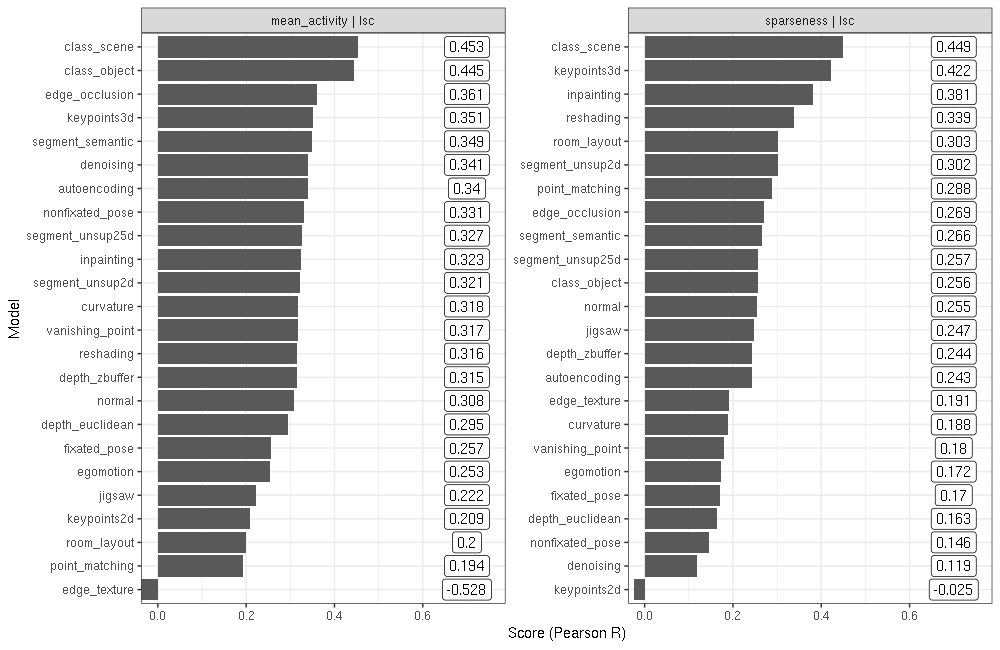

In [37]:
%%R -h 650 -w 1000 --res 100 -i reg_results -o plot_data

plot_data <- reg_results %>% mutate(score = ridge_gcv_score) %>% 
    filter(train_type == 'taskonomy') %>%
    filter(image_type %in% c('lsc')) %>%
    filter(!str_detect(model,'random_weights')) %>%
    mutate(rank = sprintf("%02i", as.integer(rank(score))))
    
plot_data %>% 
      {ggplot(., aes(rank, score)) +
      geom_bar(stat = 'identity', position = 'identity') + 
      xlab('Model') + ylab('Score (Pearson R)') + labs(fill = 'Task Cluster') +
      scale_x_discrete(labels = with(., model %>% set_names(rank))) +
      facet_wrap(~interaction(metric, image_type, sep = ' | '), scales = 'free') +
      geom_label(aes(y = 0.7, label = round(score, 3)), show.legend = FALSE) +
      theme(legend.position="bottom",
            legend.justification="center", 
            legend.box.margin=margin(-12,0,0,0)) +
      coord_flip(ylim = c(0,0.75), clip = 'on') + theme_bw()}
    
#print(with(plot_data, model %>% set_names(rank)))

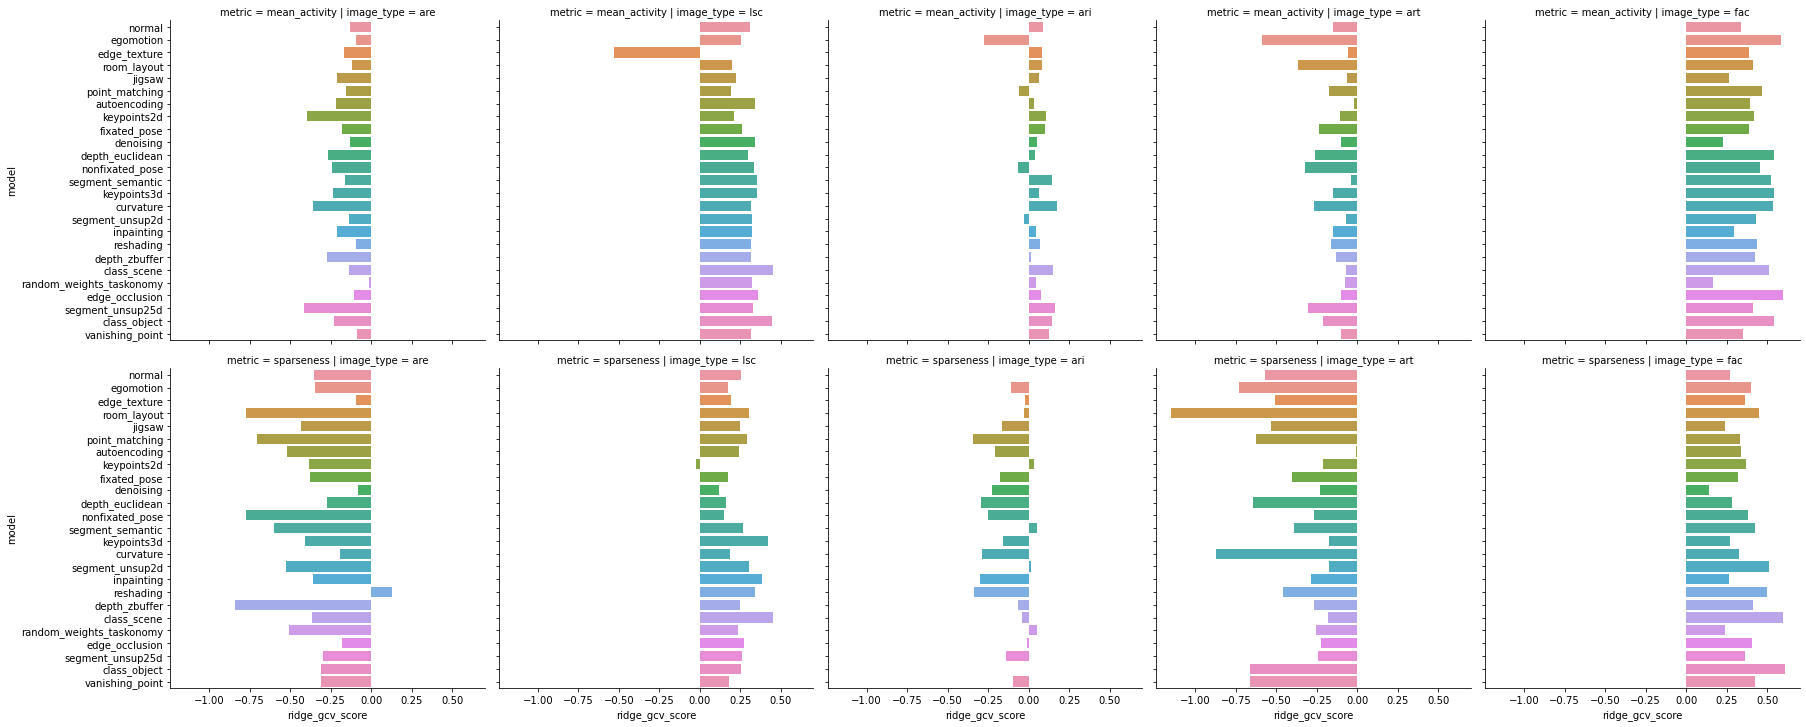

In [38]:
plot_data = reg_results.query("train_type == 'taskonomy'")

sns.catplot(x='ridge_gcv_score', y='model', col = 'image_type', row = 'metric', kind = 'bar', dodge = False, 
            data=plot_data);

(SpearmanrResult(correlation=0.16605008728293924, pvalue=0.3893082697167569),
 (0.21005313086082306, 0.27409884937269857))

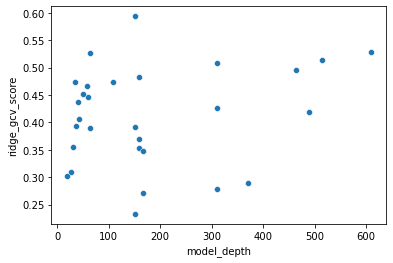

In [39]:
from scipy.stats import pearsonr, spearmanr
x = reg_results.query("image_type == 'lsc' & metric == 'sparseness' & train_type == 'imagenet'")['model_depth']
y = reg_results.query("image_type == 'lsc' & metric == 'sparseness' & train_type == 'imagenet'")['ridge_gcv_score']
sns.scatterplot(x,y); spearmanr(x,y), pearsonr(x,y)

(SpearmanrResult(correlation=0.27954643223115927, pvalue=0.14192817021296267),
 (0.19636227774596685, 0.3072961614286698))

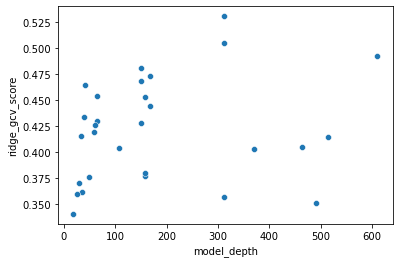

In [40]:
from scipy.stats import pearsonr, spearmanr
x = reg_results.query("image_type == 'lsc' & metric == 'mean_activity' & train_type == 'imagenet'")['model_depth']
y = reg_results.query("image_type == 'lsc' & metric == 'mean_activity' & train_type == 'imagenet'")['ridge_gcv_score']
sns.scatterplot(x,y); spearmanr(x,y), pearsonr(x,y)

In [42]:
(max_transform(reg_results, group_vars = ['metric', 'image_type'], measure_var = 'ridge_gcv_score')
 .sort_values(by=['ridge_gcv_score']))

,model,train_type,image_type,metric,model_depth,ridge_gcv_score,ridge_gcv_alpha,ridge_max_layer,ridge_max_depth,ridge_depth_coef,ridge_max_relative_depth,corr_max_score,corr_max_layer,corr_max_depth,corr_depth_coef,corr_max_relative_depth
0,vgg16,imagenet,art,sparseness,36,0.10715,10.00,Conv2d-11,24,-0.00019,0.66667,0.28388,ReLU-15,35,-0.00339,0.97222
6,vgg19,imagenet,are,mean_activity,42,0.18583,1.00,Conv2d-4,7,0.00095,0.16667,0.38577,MaxPool2d-5,37,0.00725,0.88095
9,resnet50,imagenet,art,mean_activity,158,0.19577,10.00,ReLU-27,87,0.00011,0.55063,0.28745,ReLU-27,88,-0.00010,0.55696
7,vgg19,imagenet,are,sparseness,42,0.21289,3.00,ReLU-12,26,-0.00078,0.61905,0.34165,Linear-1,38,0.00169,0.90476
1,alexnet,imagenet,ari,mean_activity,18,0.32163,0.50,Linear-2,15,0.01014,0.83333,0.44348,ReLU-4,10,0.00574,0.55556
5,squeezenet1_1,imagenet,ari,sparseness,64,0.35580,10.00,Conv2d-18,42,-0.00035,0.65625,0.40924,MaxPool2d-1,3,-0.00221,0.04688
2,resnet101,imagenet,lsc,mean_activity,311,0.53086,10.00,Conv2d-50,145,-0.00000,0.46624,0.59643,BatchNorm2d-92,273,0.00010,0.87781
8,mnasnet0_5,imagenet,lsc,sparseness,151,0.59375,0.50,ReLU-31,131,-0.00038,0.86755,0.34906,BatchNorm2d-44,125,0.00002,0.82781
3,densenet121,imagenet,fac,mean_activity,370,0.64785,10.00,Conv2d-41,127,-0.00001,0.34324,0.38769,ReLU-5,15,0.00004,0.04054
4,densenet201,imagenet,fac,sparseness,610,0.76699,0.01,Conv2d-192,582,-0.00000,0.95410,0.61630,Conv2d-94,287,-0.00013,0.47049


### Regression Permutations

In [47]:
target_model = 'densenet201_imagenet'
data_wide = process_model_data(target_model)
model_layers = data_wide['model_layer'].unique()
model_name = model_options[target_model]['model_name']
train_type = model_options[target_model]['train_type']

data_i = data_wide[(data_wide['image_type'] == 'lsc')]
y = data_i[(data_i['model_layer']==model_layers[0])]['rating'].to_numpy()
X = np.stack([data_i[(data_i['model_layer']==model_layer)]['mean_activity'].to_numpy() 
              for model_layer in model_layers], axis = 1)
alpha_values = np.array([0.01, 0.5, 1.0, 1.5, 3.0, 5.0, 10.0])
regression = RidgeCV(alphas=alpha_values, store_cv_values=True, 
                     scoring='explained_variance').fit(X,y)
ridge_gcv_score = regression.best_score_; print(ridge_gcv_score)

0.5012123957632284


In [ ]:
permuted_ridge_gcv_scores = []
for i in tqdm(range(100)):
    y = np.random.permutation(data_i[(data_i['model_layer']==model_layers[0])]['rating'].to_numpy())
    X = np.stack([data_i[(data_i['model_layer']==model_layer)]['mean_activity'].to_numpy() 
              for model_layer in model_layers], axis = 1)
    alpha_values = np.array([0.01, 0.5, 1.0, 1.5, 3.0, 5.0, 10.0])
    regression = RidgeCV(alphas=alpha_values, store_cv_values=True, 
                         scoring='explained_variance').fit(X,y)
    permuted_ridge_gcv_scores.append(regression.best_score_)

In [ ]:
sns.displot(permuted_ridge_gcv_scores);

In [ ]:
random_activity_gcv_scores = np.zeros(100)
for i in tqdm(range(100)):
    y = data_i[(data_i['model_layer']==model_layers[0])]['rating'].to_numpy()
    X = np.stack([data_i[(data_i['model_layer']==model_layer)]['mean_activity'].to_numpy() 
              for model_layer in model_layers], axis = 1)
    X = np.random.randn(*X.shape)
    alpha_values = np.array([0.01, 0.5, 1.0, 1.5, 3.0, 5.0, 10.0])
    regression = RidgeCV(alphas=alpha_values, store_cv_values=True, 
                         scoring='explained_variance').fit(X,y)
    random_activity_gcv_scores[i] = regression.best_score_

In [ ]:
sns.displot(random_activity_gcv_scores);

### Combo Regressions

In [51]:
target_model = 'alexnet_imagenet'
data_wide = process_model_data(target_model)
model_layers = data_wide['model_layer'].unique()
model_name = model_options[target_model]['model_name']
train_type = model_options[target_model]['train_type']

In [52]:
data_i = data_wide[(data_wide['image_type'] == 'lsc')]
y = data_i[(data_i['model_layer']==model_layers[0])]['rating'].to_numpy()
X1 = np.stack([data_i[(data_i['model_layer']==model_layer)]['mean_activity'].to_numpy() 
              for model_layer in model_layers], axis = 1)
X2 = np.stack([data_i[(data_i['model_layer']==model_layer)]['sparseness'].to_numpy() 
              for model_layer in model_layers], axis = 1)
X = np.concatenate([X1, X2], axis = 1)
alpha_values = np.array([0.01, 0.5, 1.0, 1.5, 3.0, 5.0, 10.0])
regression = RidgeCV(alphas=alpha_values, store_cv_values=True, 
                     scoring='explained_variance').fit(X,y)
ridge_gcv_score = regression.best_score_; print(ridge_gcv_score)

0.37747498288304626


In [57]:
model_csvs = glob('metrics/vessel/*.csv')
target_models = [csv.split('/')[-1].split('.')[0] for csv in model_csvs]
target_models = [model for model in target_models if 'googlenet' not in model]

output_file = 'results/combo_regressions2.csv'
if os.path.exists(output_file):
    combo_reg_results = pd.read_csv(output_file)

if not os.path.exists(output_file):
    results_dictlist = []
    iterator = tqdm(target_models)
    for target_model in iterator:
        iterator.set_description(target_model) 
        data_wide = process_model_data(target_model)
        model_layers = data_wide['model_layer'].unique()
        model_name = model_options[target_model]['model_name']
        train_type = model_options[target_model]['train_type']

        for image_type in tqdm(data_wide['image_type'].unique(), leave=False):
            data_i = data_wide[(data_wide['image_type'] == image_type)]
            y = data_i[(data_i['model_layer']==model_layers[0])]['rating'].to_numpy()
            X1 = np.stack([data_i[(data_i['model_layer']==model_layer)]['mean_activity'].to_numpy() 
                           for model_layer in model_layers], axis = 1)
            X2 = np.stack([data_i[(data_i['model_layer']==model_layer)]['sparseness'].to_numpy() 
                           for model_layer in model_layers], axis = 1)
            X = np.concatenate([X1, X2], axis = 1)
            alpha_values = np.array([0.01, 0.5, 1.0, 1.5, 3.0, 5.0, 10.0])
            regression = RidgeCV(alphas=alpha_values, store_cv_values=True, 
                                 scoring='explained_variance').fit(X,y)
            ridge_gcv_score, ridge_gcv_alpha = regression.best_score_, regression.alpha_

            results_dictlist.append({'model': model_name, 'train_type': train_type, 
                                     'image_type': image_type, 'metric': 'combo',
                                     'model_depth': len(model_layers),
                                     'ridge_gcv_score': ridge_gcv_score,
                                     'ridge_gcv_alpha': ridge_gcv_alpha})
            
    combo_reg_results = pd.DataFrame(results_dictlist)
    combo_reg_results.to_csv(output_file, index = None)

In [60]:
(max_transform(combo_reg_results, measure_var = 'ridge_gcv_score', group_vars = ['image_type', 'metric'])
 .sort_values(by='ridge_gcv_score'))

,model,train_type,image_type,metric,model_depth,ridge_gcv_score,ridge_gcv_alpha
4,resnet152,imagenet,art,combo,464,0.134013,0.50
3,vgg19,imagenet,are,combo,42,0.191294,0.50
1,densenet201,imagenet,ari,combo,610,0.353620,0.50
0,resnext101_32x8d,imagenet,lsc,combo,311,0.549633,0.01
2,densenet201,imagenet,fac,combo,610,0.778220,0.01


In [61]:
(max_transform(reg_results, measure_var = 'ridge_gcv_score', group_vars = ['image_type','metric'])
 .sort_values(by='ridge_gcv_score')).loc[:,:'ridge_gcv_alpha']

,model,train_type,image_type,metric,model_depth,ridge_gcv_score,ridge_gcv_alpha
0,vgg16,imagenet,art,sparseness,36,0.10715,10.00
6,vgg19,imagenet,are,mean_activity,42,0.18583,1.00
9,resnet50,imagenet,art,mean_activity,158,0.19577,10.00
7,vgg19,imagenet,are,sparseness,42,0.21289,3.00
1,alexnet,imagenet,ari,mean_activity,18,0.32163,0.50
5,squeezenet1_1,imagenet,ari,sparseness,64,0.35580,10.00
2,resnet101,imagenet,lsc,mean_activity,311,0.53086,10.00
8,mnasnet0_5,imagenet,lsc,sparseness,151,0.59375,0.50
3,densenet121,imagenet,fac,mean_activity,370,0.64785,10.00
4,densenet201,imagenet,fac,sparseness,610,0.76699,0.01


### Stepwise Regressions

In [63]:
model_csvs = glob('metrics/vessel/*.csv')
#target_models = [csv.split('/')[1].split('.')[0] for csv in model_csvs]
target_models = ['alexnet_imagenet','alexnet_random']

output_file = 'results/stepwise_regressions2.csv'
if os.path.exists(output_file):
    step_reg_results = pd.read_csv(output_file)

if not os.path.exists(output_file):
    results_dictlist = []
    iterator = tqdm(target_models)
    for target_model in iterator:
        iterator.set_description(target_model) 
        data_wide = process_model_data(target_model)
        data_long = process_model_data(target_model, orient='long')
        model_layers = data_wide['model_layer'].unique()

        for metric in tqdm(data_long['metric'].unique(), leave=False):
            for image_type in tqdm(data_long['image_type'].unique(), leave=False):
                running_model_layer_list = []
                for model_layer_index, model_layer in enumerate(tqdm(model_layers, leave = False)):
                    running_model_layer_list.append(model_layer)
                    
                    data_i = data_wide[(data_wide['image_type'] == image_type)]
                    y = data_i[(data_i['model_layer']==model_layers[0])]['rating'].to_numpy()
                    X = np.stack([data_i[(data_i['model_layer']==model_layer)][metric].to_numpy() 
                                  for model_layer in running_model_layer_list], axis = 1)
                    regression = RidgeCV(alphas=[1.0], store_cv_values=True, scoring='explained_variance').fit(X,y)
                    ridge_gcv_score, ridge_gcv_alpha = regression.best_score_, regression.alpha_
                    results_dictlist.append({'model': model_name, 'train_type': train_type,
                                             'image_type': image_type, 'metric': metric,
                                             'score': ridge_gcv_score, 
                                             'alpha': ridge_gcv_alpha,
                                             'model_layer': model_layer,
                                             'model_depth': len(model_layers),
                                             'model_layer_index': model_layer_index + 1,
                                             'model_layer_depth': (model_layer_index + 1) / len(model_layers)})

    step_reg_results = pd.DataFrame(results_dictlist)
    #reg_results.to_csv(output_file, index = None)

In [64]:
step_reg_results

,model,train_type,image_type,metric,score,alpha,model_layer,model_depth,model_layer_index,model_layer_depth
0,wide_resnet101_2,random,are,mean_activity,-0.018339,0.50,Conv2d-1,311,1,0.003215
1,wide_resnet101_2,random,are,mean_activity,-0.018339,1.00,BatchNorm2d-1,311,2,0.006431
2,wide_resnet101_2,random,are,mean_activity,-0.018608,1.50,ReLU-1,311,3,0.009646
3,wide_resnet101_2,random,are,mean_activity,-0.018884,10.00,MaxPool2d-1,311,4,0.012862
4,wide_resnet101_2,random,are,mean_activity,-0.019033,10.00,Conv2d-2,311,5,0.016077
...,...,...,...,...,...,...,...,...,...,...
149745,vanishing_point,taskonomy,fac,sparseness,0.409620,0.01,ReLU-49,162,158,0.975309
149746,vanishing_point,taskonomy,fac,sparseness,0.415174,0.01,Conv2d-54,162,159,0.981481
149747,vanishing_point,taskonomy,fac,sparseness,0.419537,0.01,BatchNorm2d-54,162,160,0.987654
149748,vanishing_point,taskonomy,fac,sparseness,0.418402,0.01,ReLU-50,162,161,0.993827


In [65]:
max_transform(step_reg_results, group_vars = ['metric','image_type']).sort_values(by='score')

,model,train_type,image_type,metric,score,alpha,model_layer,model_depth,model_layer_index,model_layer_depth
7,resnet152,imagenet,art,mean_activity,0.140473,0.01,ReLU-126,464,385,0.829741
9,resnet152,imagenet,art,sparseness,0.174203,0.50,ReLU-129,464,394,0.849138
8,resnet152,imagenet,are,sparseness,0.253886,0.01,BatchNorm2d-132,464,393,0.846983
2,densenet201,imagenet,are,mean_activity,0.273196,0.01,ReLU-179,610,543,0.890164
0,alexnet,imagenet,ari,mean_activity,0.337805,0.01,ReLU-7,18,17,0.944444
4,densenet201,imagenet,ari,sparseness,0.375775,0.50,ReLU-182,610,552,0.904918
6,densenet169,imagenet,lsc,mean_activity,0.539780,0.01,BatchNorm2d-169,514,513,0.998054
3,densenet201,imagenet,lsc,sparseness,0.589041,0.01,Conv2d-170,610,517,0.847541
1,densenet121,imagenet,fac,mean_activity,0.664910,0.01,Linear-1,370,370,1.000000
5,densenet201,imagenet,fac,sparseness,0.783337,0.01,Conv2d-193,610,586,0.960656


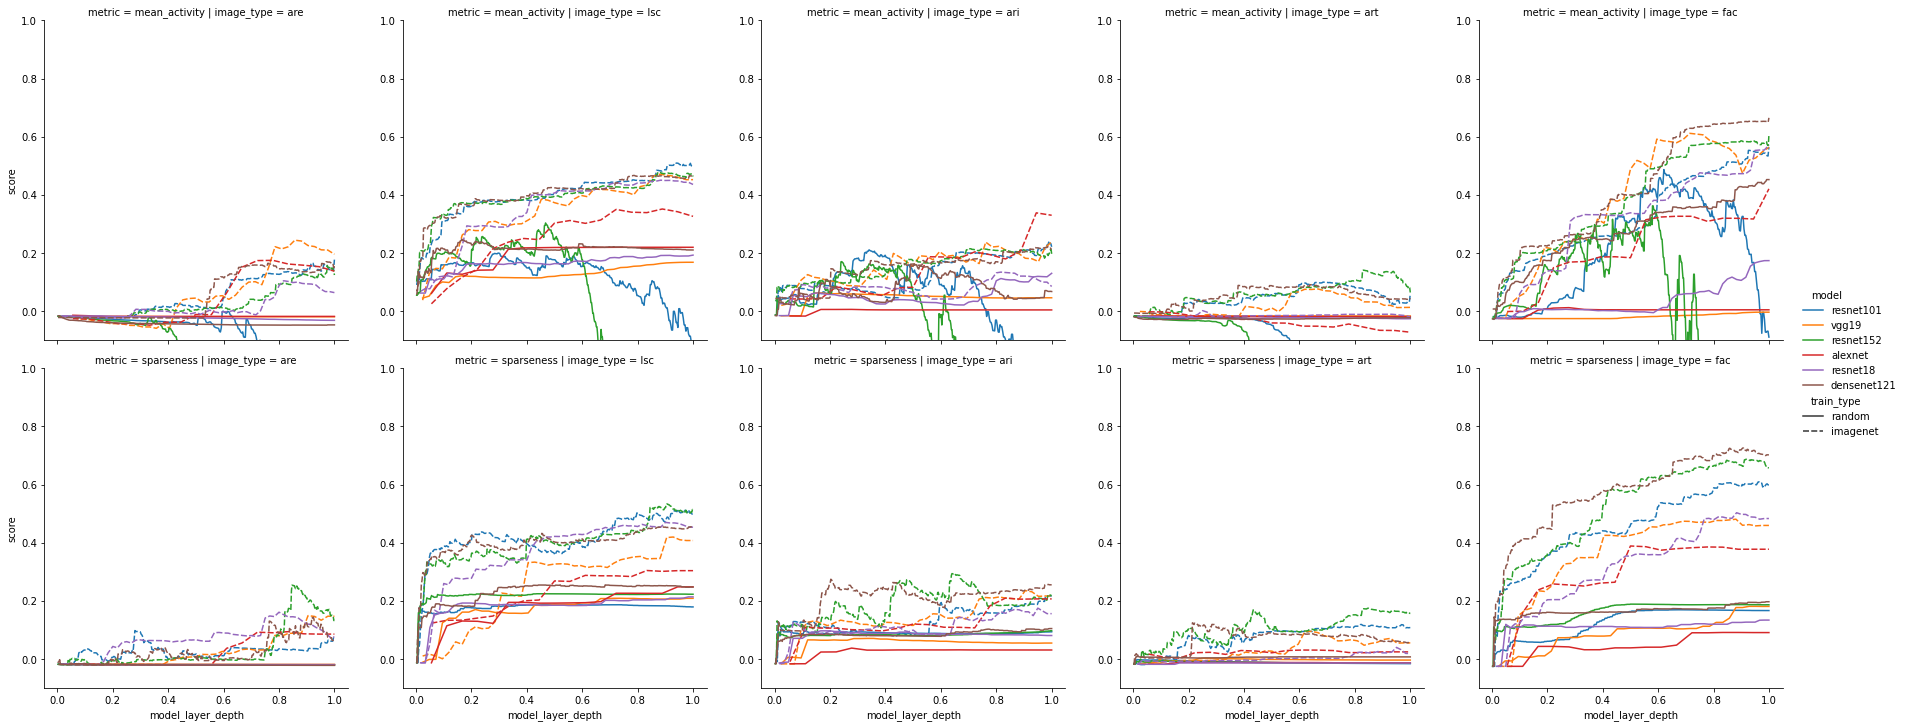

In [66]:
target_models = ['alexnet','vgg19','resnet18', 'densenet121','resnet101','resnet152']

plotting_subset = step_reg_results[(step_reg_results['metric'].isin(['mean_activity','sparseness'])) &
                                   (step_reg_results['model'].isin(target_models))]
p = sns.relplot(x = 'model_layer_depth', y = 'score', hue = 'model', col = 'image_type', row = 'metric', style = 'train_type', 
            kind = 'line', ci = False, data = plotting_subset, facet_kws={'sharey': False});
p.set(ylim=(-0.1,1.0));

In [67]:
max_transform(plotting_subset, measure_var = 'score', group_vars = ['image_type','metric']).sort_values(by='score')

,model,train_type,image_type,metric,score,alpha,model_layer,model_depth,model_layer_index,model_layer_depth
5,resnet152,imagenet,art,mean_activity,0.140473,0.01,ReLU-126,464,385,0.829741
9,resnet152,imagenet,art,sparseness,0.174203,0.50,ReLU-129,464,394,0.849138
4,vgg19,imagenet,are,mean_activity,0.243754,0.01,ReLU-16,42,36,0.857143
6,resnet152,imagenet,are,sparseness,0.253886,0.01,BatchNorm2d-132,464,393,0.846983
8,resnet152,imagenet,ari,sparseness,0.295128,0.01,BatchNorm2d-101,464,300,0.646552
0,alexnet,imagenet,ari,mean_activity,0.337805,0.01,ReLU-7,18,17,0.944444
1,resnet101,imagenet,lsc,mean_activity,0.510784,0.01,ReLU-94,311,291,0.935691
7,resnet152,imagenet,lsc,sparseness,0.533812,0.01,BatchNorm2d-141,464,420,0.905172
2,densenet121,imagenet,fac,mean_activity,0.664910,0.01,Linear-1,370,370,1.000000
3,densenet121,imagenet,fac,sparseness,0.725736,0.01,BatchNorm2d-110,370,335,0.905405


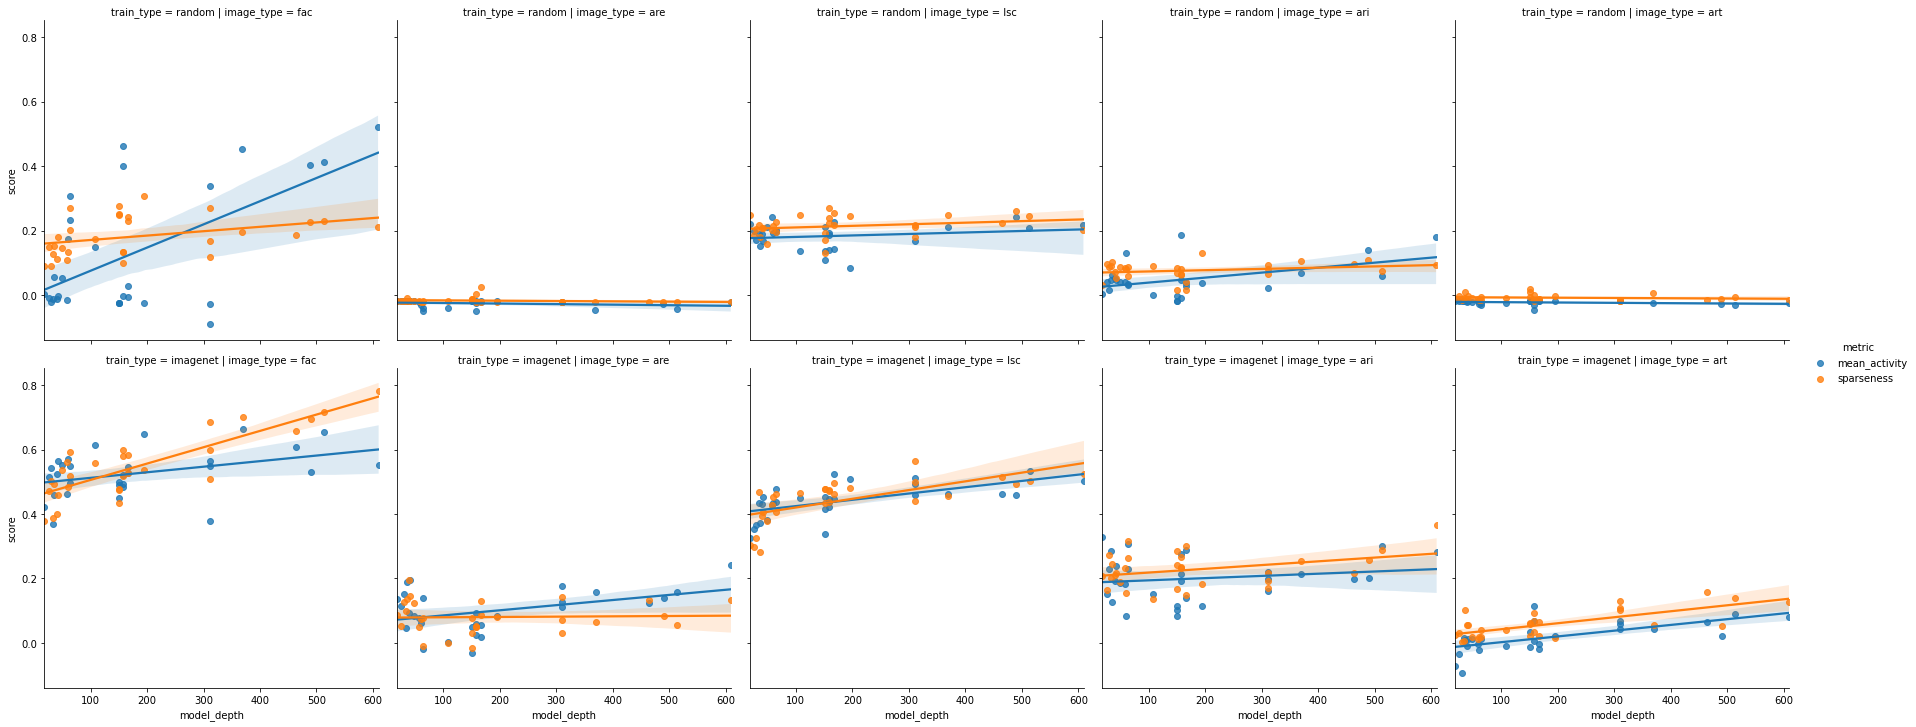

In [68]:
plotting_subset = step_reg_results[(step_reg_results['metric'].isin(['mean_activity','sparseness'])) &
                                   ~(step_reg_results['train_type'].isin(['taskonomy'])) & 
                                   (step_reg_results['model_layer_depth'] == 1.0) & 
                                   (step_reg_results['score'] > -0.1)]

sns.lmplot(x = 'model_depth', y = 'score', col = 'image_type', row = 'train_type', hue = 'metric', data = plotting_subset);

In [69]:
corr_subset = corr_results[(corr_results['model'] == 'vgg19') & (corr_results['image_type'].isin(['lsc'])) &
                           (corr_results['metric'].isin(['mean_activity','sparseness']))]

In [71]:
max_transform(corr_subset, group_vars = ['metric'], measure_var = 'corr')

,model,train_type,image_type,model_layer,model_layer_depth,metric,corr,corr_abs,corr_sq
0,vgg19,imagenet,lsc,ReLU-15,34,mean_activity,0.575970,0.575970,0.331741
1,vgg19,imagenet,lsc,Linear-1,38,sparseness,0.474991,0.474991,0.225616


In [72]:
plot_data = process_model_data('alexnet_imagenet')
plot_data = plot_data[plot_data['image_type'] == 'lsc']

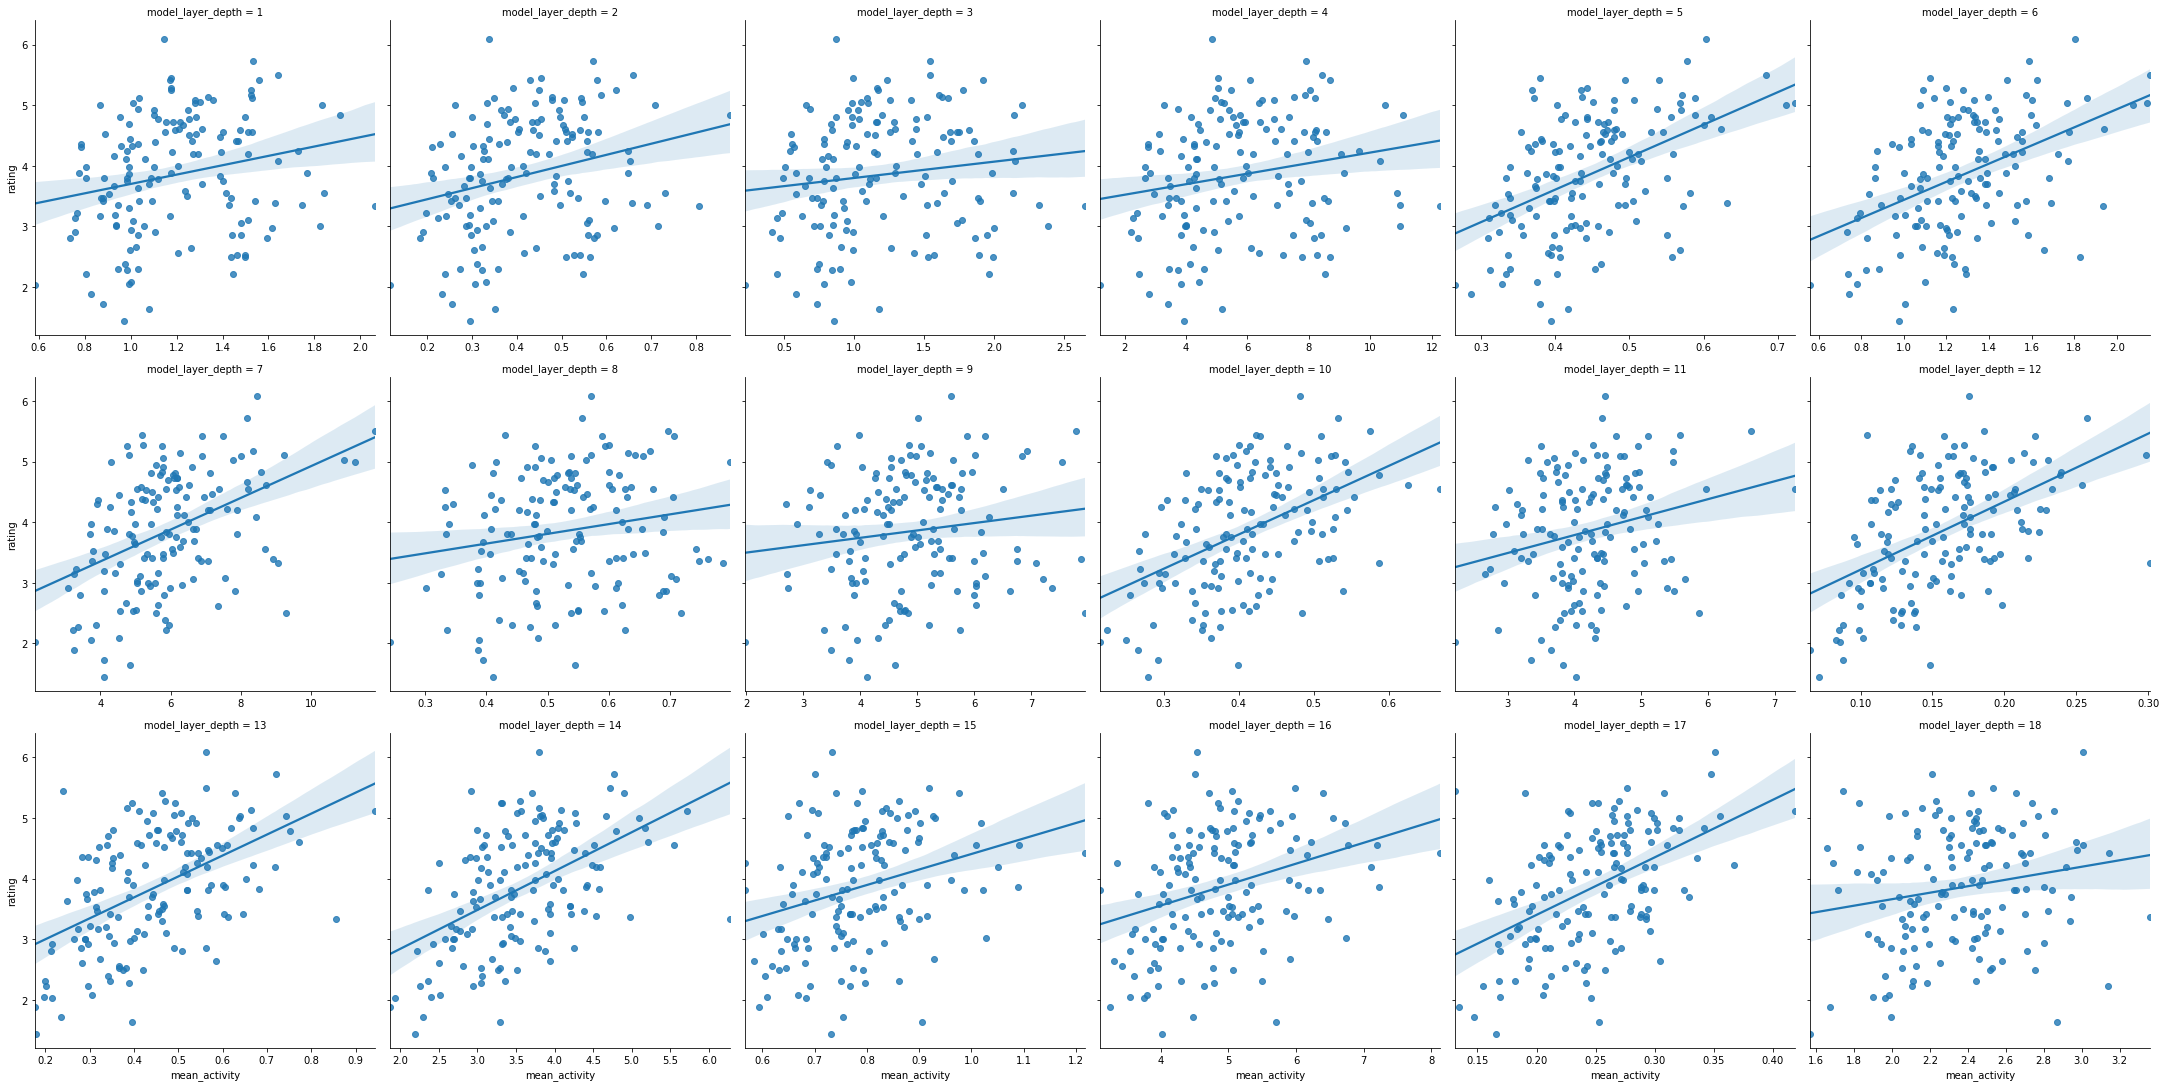

In [73]:
sns.lmplot(x = 'mean_activity', y = 'rating', col = 'model_layer_depth', order = 1, col_wrap = 6, 
            data=plot_data, sharex = False);

### Feature Regression

In [78]:
model_data = (pd.read_csv('regression/oasis/{}.csv'.format('alexnet_imagenet')))
model_data = model_data.rename(columns={'score': 'ridge_gcv_score', 'penalty':'ridge_penalty'})

In [79]:
model_depths = reg_results.groupby(['model','train_type'])['model_depth'].mean().reset_index()

In [81]:
model_csvs = glob('regression/oasis/*.csv')
target_models = [csv.split('/')[-1].split('.')[0] for csv in model_csvs]
target_models = [model for model in target_models if 'googlenet' not in model]

output_file = 'results/oasis_regression.csv'
if os.path.exists(output_file):
    neural_reg_results = pd.read_csv(output_file)

if not os.path.exists(output_file):
    results_dflist = []
    iterator = tqdm(target_models)
    for target_model in iterator:
        iterator.set_description(target_model) 
        model_data = (pd.read_csv('regression/oasis/{}.csv'.format(target_model)))
        model_data['model_layer_index'] = model_data['model_layer_depth']
        model_data['model_depth'] = len(model_data['model_layer_index'].unique())
        #model_data = model_data.merge(model_depths, on = ['model','train_type'])
        model_data['model_layer_depth'] = model_data['model_layer_depth'] / model_data['model_depth']
         
        results_dflist.append(model_data)

    neural_reg_results = pd.concat(results_dflist)
    neural_reg_results.to_csv(output_file, index = None)

  0%|          | 0/83 [00:00<?, ?it/s]

In [82]:
max_transform(neural_reg_results, measure_var = 'score', group_vars = ['category']).sort_values(by='score')

,model,train_type,model_layer,model_layer_depth,category,measurement,score,penalty,model_layer_index,model_depth
2,vgg16_bn,imagenet,ReLU-15,0.979592,Person,beauty,0.495586,215.443469,48,49
4,vgg19,imagenet,Linear-3,1.000000,Object,valence,0.574017,4641.588834,42,42
3,vgg16_bn,imagenet,ReLU-15,0.979592,Combo,beauty,0.623105,278.255940,48,49
0,resnet152,imagenet,AdaptiveAvgPool2d-1,0.997845,Animal,beauty,0.687116,59.948425,463,464
1,densenet161,imagenet,BatchNorm2d-161,0.997959,Scene,beauty,0.762551,0.100000,489,490


In [83]:
reg_layer_max = max_transform(neural_reg_results, measure_var = 'score', 
                              group_vars = ['model','train_type','category', 'measurement']).sort_values(by='score')

In [84]:
pg.pairwise_ttests(data = reg_layer_max[reg_layer_max['train_type'] != 'random'], 
                   dv = 'score', between = ['measurement'], subject = 'model')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,measurement,arousal,beauty,False,True,-6.085353,538.0,two-sided,2.209504e-09,3.89e+06,-0.523013
1,measurement,arousal,valence,False,True,-2.566178,538.0,two-sided,1.055217e-02,2.328,-0.220553
2,measurement,beauty,valence,False,True,3.590894,538.0,two-sided,3.597197e-04,48.019,0.308624


In [85]:
pg.pairwise_ttests(data = reg_layer_max[reg_layer_max['train_type'] == 'imagenet'], 
                   dv = 'score', between = ['measurement'], subject = 'model', padjust = 'bonf')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,measurement,arousal,beauty,False,True,-10.700070,288.0,two-sided,1.020286e-22,3.060857e-22,bonf,3.273e+19,-1.253384
1,measurement,arousal,valence,False,True,-6.147203,288.0,two-sided,2.622722e-09,7.868167e-09,bonf,3.588e+06,-0.720071
2,measurement,beauty,valence,False,True,6.054140,288.0,two-sided,4.391932e-09,1.317580e-08,bonf,2.2e+06,0.709169


In [86]:
neural_reg_results.groupby(['train_type','category'])['score'].max().reset_index()

,train_type,category,score
0,imagenet,Animal,0.687116
1,imagenet,Combo,0.623105
2,imagenet,Object,0.574017
3,imagenet,Person,0.495586
4,imagenet,Scene,0.762551
5,random,Animal,0.129505
6,random,Combo,0.139093
7,random,Object,0.219300
8,random,Person,0.052863
9,random,Scene,0.404128


In [87]:
neural_reg_results.groupby(['model','category'])['score'].mean().reset_index().sort_values(by='score')

,model,category,score
148,resnet152,Person,-0.022653
65,edge_texture,Animal,-0.000276
25,denoising,Animal,-0.000202
85,jigsaw,Animal,0.002590
218,vanishing_point,Person,0.002609
...,...,...,...
254,vgg19,Scene,0.274532
4,alexnet,Scene,0.277967
14,class_object,Scene,0.286670
169,resnext101_32x8d,Scene,0.288567


`summarise()` has grouped output by 'model', 'train_type', 'measurement'. You can override using the `.groups` argument.


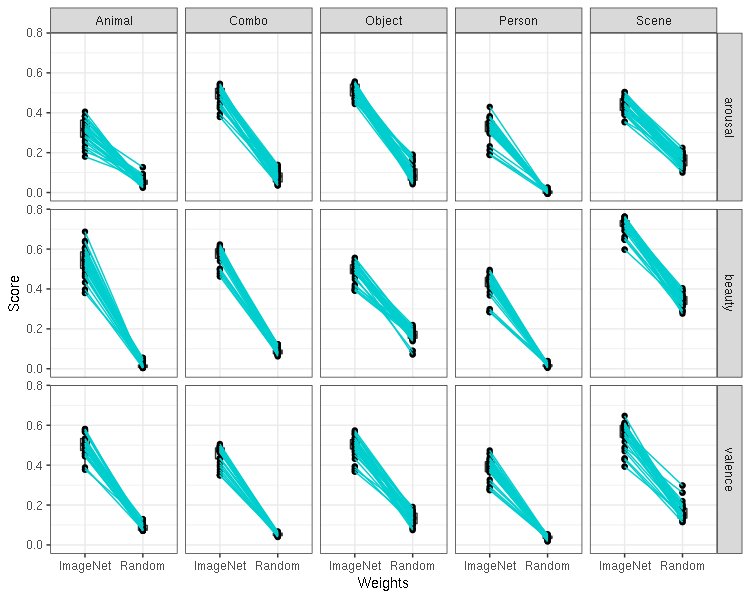

In [88]:
%%R -h 600 -w 750 --res 100 -i neural_reg_results -o pairplot_data

pairplot_data <- neural_reg_results %>%
    filter(train_type != 'taskonomy') %>%
    group_by(model, train_type, measurement, category) %>% 
    summarise(score = max(score)) %>%
    group_by(model, measurement, category) %>%
    mutate(slope = (score[train_type=='imagenet'] - score[train_type=='random'])/(2-1)) %>%
    mutate(train_type = fct_recode(as.factor(train_type), ImageNet = 'imagenet', Random = 'random'))

pairplot_data %>%
    ggplot(aes(train_type, score)) + 
    facet_grid(measurement~category) +
    geom_boxplot(width = 0.15) + geom_point() + 
    geom_line(aes(group=model, col = slope > 0)) +
    scale_color_manual(values= c('TRUE' = 'cyan3', 'FALSE' = 'red3')) +
    theme_bw() + ylab('Score') + xlab('Weights') + guides(color = FALSE)

In [89]:
pairplot_data[pairplot_data['model'] == 'alexnet']

,model,train_type,measurement,category,score,slope
1,alexnet,ImageNet,arousal,Animal,0.278006,0.220011
2,alexnet,ImageNet,arousal,Combo,0.422338,0.311385
3,alexnet,ImageNet,arousal,Object,0.467314,0.283850
4,alexnet,ImageNet,arousal,Person,0.192259,0.183701
5,alexnet,ImageNet,arousal,Scene,0.407575,0.231947
6,alexnet,ImageNet,beauty,Animal,0.517503,0.462857
7,alexnet,ImageNet,beauty,Combo,0.496198,0.413809
8,alexnet,ImageNet,beauty,Object,0.393843,0.220545
9,alexnet,ImageNet,beauty,Person,0.298337,0.271484
10,alexnet,ImageNet,beauty,Scene,0.694035,0.303389


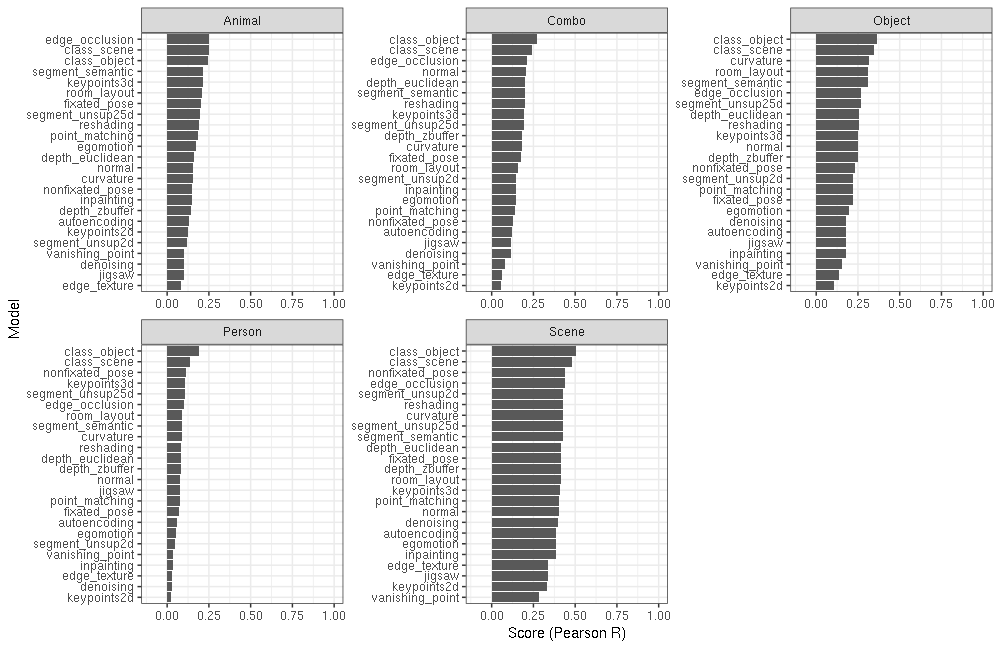

In [90]:
%%R -h 650 -w 1000 --res 100 -i neural_reg_results -o plot_data

plot_data <- neural_reg_results %>% 
    group_by(model, train_type, category) %>%
    filter(score == max(score)) %>% ungroup() %>%
    filter(train_type == 'taskonomy') %>%
    filter(!str_detect(model,'random_weights')) %>%
    mutate(rank = sprintf("%03i", as.integer(rank(score))))
    
plot_data %>% {ggplot(., aes(rank, score)) +
      geom_bar(stat = 'identity', position = 'identity') + 
      xlab('Model') + ylab('Score (Pearson R)') + 
      scale_x_discrete(labels = with(., model %>% set_names(rank))) +
      facet_wrap(~category, scales = 'free') +
      #geom_label(aes(y = 0.85, label = round(score, 3)), show.legend = FALSE) +
      coord_flip(ylim = c(-0.1,1.0), clip = 'on') + theme_bw()}

In [91]:
plot_data[(plot_data['category'] == 'Scene') & (plot_data['measurement'] == 'beauty')].sort_values(by='rank')

,model,train_type,model_layer,model_layer_depth,category,measurement,score,penalty,model_layer_index,model_depth,rank
42,vanishing_point,taskonomy,ReLU-1,0.018519,Scene,beauty,0.282017,46415.888336,3,162,092
61,keypoints2d,taskonomy,Conv2d-18,0.322981,Scene,beauty,0.330237,46415.888336,52,161,096
57,jigsaw,taskonomy,ReLU-4,0.092593,Scene,beauty,0.337402,278255.940221,15,162,097
22,edge_texture,taskonomy,ReLU-6,0.130435,Scene,beauty,0.339457,0.100000,21,161,098
117,inpainting,taskonomy,ReLU-2,0.043478,Scene,beauty,0.384659,10000.000000,7,161,101
97,egomotion,taskonomy,BatchNorm2d-22,0.401235,Scene,beauty,0.385462,5994.842503,65,162,102
1,autoencoding,taskonomy,ReLU-2,0.043210,Scene,beauty,0.388024,4641.588834,7,162,103
48,denoising,taskonomy,ReLU-8,0.166667,Scene,beauty,0.396557,5994.842503,27,162,104
17,normal,taskonomy,BatchNorm2d-32,0.586420,Scene,beauty,0.400962,2154.434690,95,162,105
53,point_matching,taskonomy,Conv2d-14,0.253086,Scene,beauty,0.405595,0.100000,41,162,106


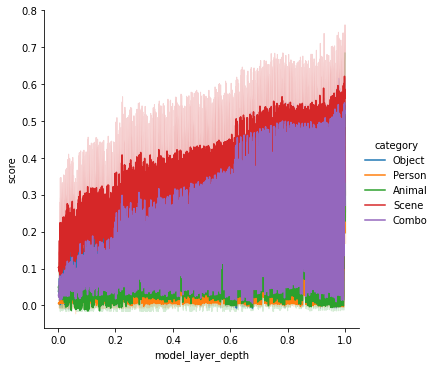

In [93]:
sns.relplot(x = 'model_layer_depth', y = 'score', hue = 'category', kind = 'line', 
            data = neural_reg_results.query("train_type != 'random'"));